# Model Training and Analysis

## Model Setup and Training

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [36]:
df = pd.read_csv("data\cleaned_insurance.csv")
target_col = 'charges'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found")

In [37]:
report = sv.analyze(df, target_feat='charges') # defining target column
report.show_html('reports\sweetviz_report.html') # generating the report

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report reports\sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [38]:
# separating target from features in dataframe
X = df.drop(columns=[target_col])
y = df[target_col]

In [39]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_df = X_train.copy()
train_df['charges'] = y_train

test_df = X_test.copy()
test_df['charges'] = y_test

In [ ]:
compare_report = sv.compare([train_df, "Training Data"],[test_df, "Test Data"], target_feat="charges")
compare_report.show_html("reports\sweetviz_train_test_comparison.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report reports\sweetviz_train_test_comparison.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [40]:
# train the model
use_xgboost = True  # False to use RandomForest instead

if use_xgboost:
    model = XGBRegressor(learning_rate=0.05, max_depth=3, random_state=0)
else:
    model = RandomForestRegressor(random_state=0)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Model Evaluation

In [41]:
# predict and evaluate with MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Test MSE: {round(mse,2):.2f}")
print(f"Model Test RMSE: {round(np.sqrt(mse),2)}")
print(f"Model Test MAE: {round(mean_absolute_error(y_test, y_pred),2)}")
print(f"Model Test R2 metric: {round(r2,2)}")

Model Test MSE: 17143845.53
Model Test RMSE: 4140.51
Model Test MAE: 2460.46
Model Test R2 metric: 0.89


Note that the MSE is in squared dollars, since the target variable being predicted is the hospital costs for a given patient. A more reasonable metric to use in this case would be the RMSE, which corresponds to around $4140.51, or the MAE, which is the average error in dollars, and is equal to $2460.46.

Comparing this model to the decision trees reveals that the XGBoost model is better at predicting hospital charges for new patients, since the model test MAE is lower and R2 metric is higher than for the decision tree.

XGBoost metrics:
- Model Test MAE: 2460.46
- Model Test R2 metric: 0.89

Decision trees metrics: 
- Mean Absolute Error: 2878.46
- R² Score: 0.84

Random Forests metrics: 
- Model Test MAE: 2794.46
- Model Test R2 metric: 0.86

However, the decision trees are more interpretable over the XGBoost model since that offer a visualisation aspect to the prediction.

In [7]:
# Small analysis of the test set
print(f"Mean charges: {round(y_test.mean(),2)}")
print(f"Median charges: {round(y_test.median(),2)}")
print(f"Standard deviation: {round(y_test.std(),2)}")

Mean charges: 13357.75
Median charges: 8796.23
Standard deviation: 12643.86


The mean is clearly different from the median, which suggests an asymmetric distribution. The figure below shows these differences in symmetry more clearly, the distribution is more adapted to lower hospital costs and is less generalizable to higher costs.

## Model Visualizations and Analysis

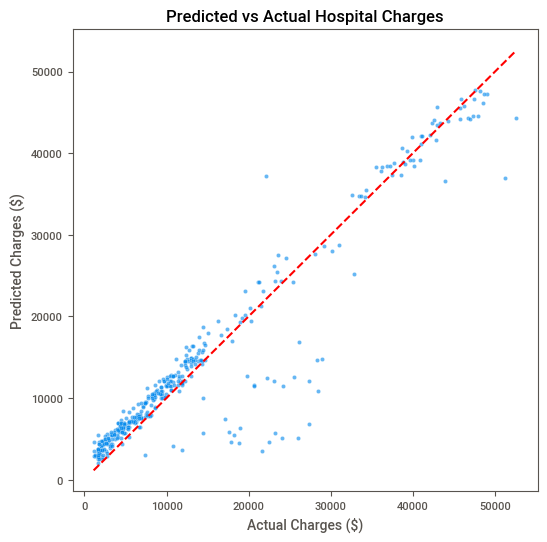

In [8]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Hospital Charges")
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.show()

The model seems to be performing well overall, the points seem to be clustered close to the target line. The model seems to underestimate very high charges and overestimate medium-size charges. Suggesting heteroskedasticity of the cost data.

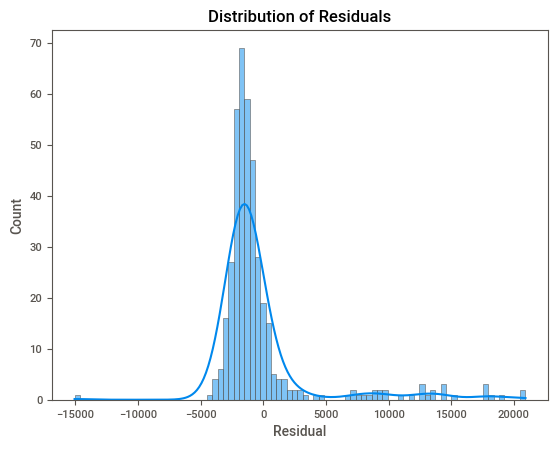

In [9]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

The residuals distribution is bell-shaped, and centered slightly below 0, meaning that the model tends to slightly overestimate charges. The right tail is longer, with positive skewness, meaning the model systematically underestimates high hospital costs.

            Feature  Importance
4            smoker    0.822805
2               bmi    0.095859
0               age    0.052389
3          children    0.011229
5  region_northwest    0.006900
7  region_southwest    0.004525
6  region_southeast    0.004465
1               sex    0.001829


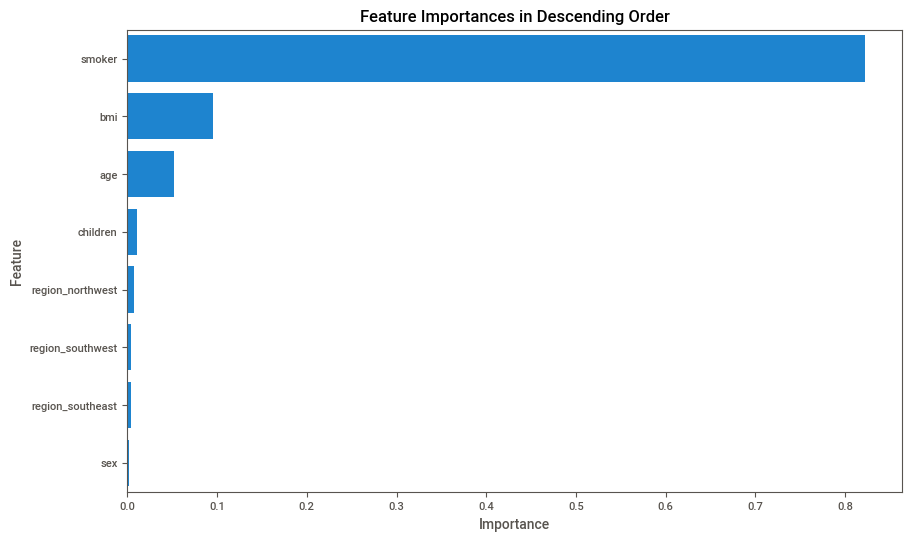

In [10]:
# variable importance analysis
importances = model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)
print(feat_imp)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title('Feature Importances in Descending Order')
plt.show()

As expected, the 3 features with the most importance are the smoker index, the bmi, and the age. 
Smoker is by far the most influential variable. To further analyse these features, we can use clustering for the patients with similar behaviours or profiles, based on the relative importance of the top 3 features. 